# Problem Set 5: Trees, Forests, and Fairness in ML


Your mission for this problem set is to use your knowledge of tree-based methods and supervised learning to -- among other things! -- explore issues of fairness in machine learning (ML). Unlike in previous psets, where we were implementing algorithms from scratch, this pset will rely more heavily on sklearn. Unless explicitly noted otherwise, you are allowed (encouraged!) to make good use of this wonderful library. 

This problem set will also rely on the resources provided by the [folktables](https://github.com/socialfoundations/folktables?tab=readme-ov-file) project. Before getting started, take some time to understand what folktables is about and how it can be used to benchmark ML algorithms in social science. If you don't understand the basics, this pset will be very challenging!!

Some resources you might find useful:

[Folktables paper](https://arxiv.org/abs/2108.04884)

[Folktables video](youtube.com/watch?v=KP7DhM_ahHI)

[PUMS_Data_Dictionary_2018](https://www2.census.gov/programssurveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2018.pdf)

[Fairness in ML](https://fairmlbook.org/classification.html)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folktables
import seaborn as sns

## Part I: Setup of prediction task

### 1.1 Define the income prediction task

For this first question we are providing the code. Run it to download the data you'll be using throughout this problem set. 

Begin by explaining what this prediction task is about and what is this code accomplishing:

* Where do the data come from
* What is the sample?
* What are we trying to predict?
* What are the features that we will be using?
* What is the "group" feature?

In [2]:
from folktables import ACSDataSource, generate_categories

def adult_filter(data):
    """Mimic the filters in place for Adult data.

    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    return df

ACSIncome = folktables.BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'POBP',
        'RELP',
        'WKHP',
        'SEX',
        'RAC1P',
    ],
    target='PINCP',
    target_transform=lambda x: x > 50000,
    group='RAC1P',
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncome.features, definition_df=definition_df)
features, target, group = ACSIncome.df_to_pandas(acs_data)

feature_names = ACSIncome.features
target_name = ACSIncome.target
group_name = ACSIncome.group
print(features.head(5))
# print(feature_names.info()) #cant run

   AGEP  COW  SCHL  MAR  POBP  RELP  WKHP  SEX  RAC1P
0  30.0  6.0  14.0  1.0   6.0  16.0  40.0  1.0    8.0
1  21.0  4.0  16.0  5.0   6.0  17.0  20.0  1.0    1.0
2  65.0  2.0  22.0  5.0   6.0  17.0   8.0  1.0    1.0
3  33.0  1.0  14.0  3.0  36.0  16.0  40.0  1.0    1.0
4  18.0  2.0  19.0  5.0   6.0  17.0  18.0  2.0    1.0


*your answer here*  

* Where do the data come from: From the ACSDataSource and the survey year is 2018, the horizon is one year, the state is CA.
* What is the sample? With the use of the function"adult_filter", the sample is the person whose age is above 16, who reported usual working hours of at least 1 hour per week in the past year, and an income of at least $100.

* What are we trying to predict? We are trying to predict the PINCP and whether an individual's income is above $50,000.
* What are the features that we will be using? Features are: AGEP(age), COW(Class of Worker),SCHL(Educational Attainment), MAR(Marital Status), POBP(Place of Birth), RELP(Relationship),WKHP(weeks worked in past 12 months), SEX(sex), RAC1P(Race).
* What is the "group" feature? RAC1P. And the "group" feature refers to a categorical variable used to divide the data into different subgroups for analysis which is also done to ensure fairness and bias mitigation in model outcomes.

### 1.2 Split into train and test

Split your data into 80%-20% train and test splits. Please use sklearn.model_selection.train_test_split and set the random_state parameter equal to 0.

In [44]:
from sklearn.model_selection import train_test_split

# your code here
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=0)

### 1.3 Explore the data and set appropriate data types

Create 2-3 figures and tables that explore the training data, and tell us what insights you can draw from those figures. Which features are best represented as numerical data types? Which features are best represented as categorical data types? Set each feature to its desired data type in both train and test splits. Make sure that the target variable in both splits is numeric before moving ahead.

        AGEP  COW  SCHL  MAR   POBP  RELP  WKHP  SEX  RAC1P
185107  46.0  2.0  22.0  1.0    6.0   0.0  45.0  2.0    9.0
141219  45.0  1.0  21.0  3.0   12.0  13.0  50.0  2.0    1.0
70552   40.0  1.0  21.0  5.0  215.0   5.0  40.0  2.0    6.0
31300   59.0  1.0  24.0  1.0  210.0   0.0  40.0  1.0    6.0
137381  23.0  1.0  19.0  5.0    6.0  11.0  40.0  2.0    1.0
AGEP     0
COW      0
SCHL     0
MAR      0
POBP     0
RELP     0
WKHP     0
SEX      0
RAC1P    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 156532 entries, 185107 to 43567
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AGEP    156532 non-null  float64
 1   COW     156532 non-null  float64
 2   SCHL    156532 non-null  float64
 3   MAR     156532 non-null  float64
 4   POBP    156532 non-null  float64
 5   RELP    156532 non-null  float64
 6   WKHP    156532 non-null  float64
 7   SEX     156532 non-null  float64
 8   RAC1P   156532 non-null  float64
d

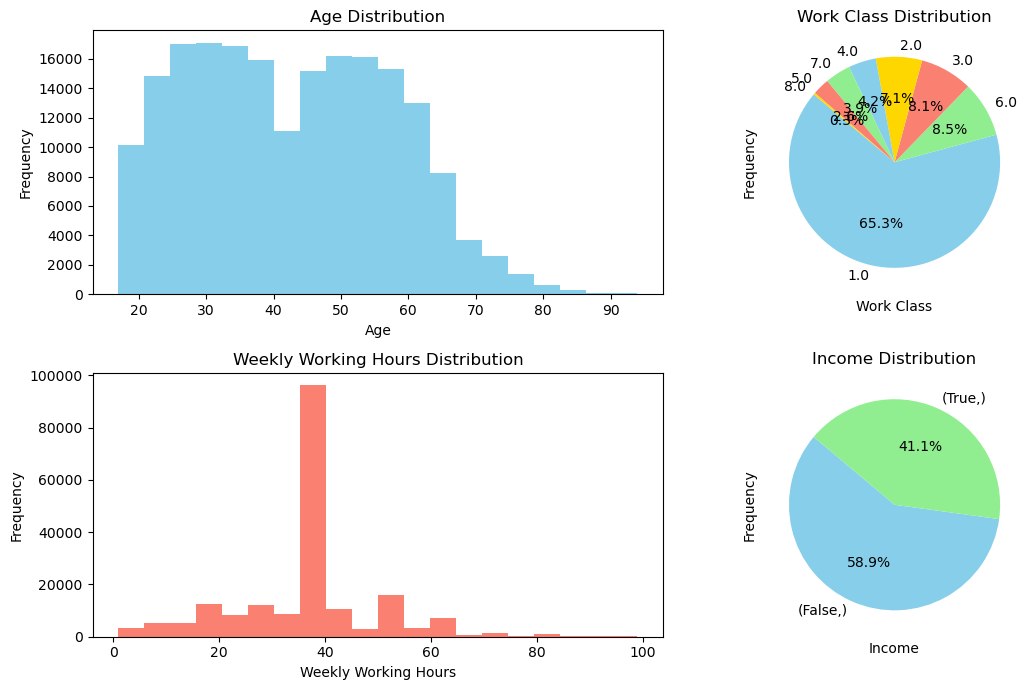

<class 'pandas.core.frame.DataFrame'>
Index: 156532 entries, 185107 to 43567
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   AGEP    156532 non-null  float64 
 1   COW     156532 non-null  category
 2   SCHL    156532 non-null  category
 3   MAR     156532 non-null  category
 4   POBP    156532 non-null  category
 5   RELP    156532 non-null  category
 6   WKHP    156532 non-null  float64 
 7   SEX     156532 non-null  category
 8   RAC1P   156532 non-null  category
dtypes: category(7), float64(2)
memory usage: 4.8 MB
None
        AGEP  COW  SCHL  MAR   POBP  RELP  WKHP  SEX RAC1P
185107  46.0  2.0  22.0  1.0    6.0   0.0  45.0  2.0   9.0
141219  45.0  1.0  21.0  3.0   12.0  13.0  50.0  2.0   1.0
70552   40.0  1.0  21.0  5.0  215.0   5.0  40.0  2.0   6.0
31300   59.0  1.0  24.0  1.0  210.0   0.0  40.0  1.0   6.0
137381  23.0  1.0  19.0  5.0    6.0  11.0  40.0  2.0   1.0


In [4]:
#your code here
print(X_train.head(5))
# get the sum of null values
missing_values_Xtrain = X_train.isnull().sum()
print(missing_values_Xtrain)
# missing_values_Xtest = X_test.isnull().sum()
# print(missing_values_Xtest)
# missing_values_ytrain = y_train.isnull().sum()
# print(missing_values_ytrain)
print(X_train.info())
print(target.info())
# print(X_test.info())
# print(y_train.info())
# print(y_test.info())
### there are no null values
### PINCP is bool-type value
## the numerical data types: AGEP, WKHP
## the categorical data types: COW, SCHL, MAR, POBP, RELP, SEX, RAC1P
# bar plots for categorical data
plt.figure(figsize=(12, 7))
plt.subplot(2, 2, 1) 
plt.hist(features['AGEP'], bins=20, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Work Class ('COW') Distribution
plt.subplot(2, 2, 2)  
# features['COW'].value_counts().plot(kind='bar', color='lightgreen')
features['COW'].value_counts().plot(
    kind='pie', 
    autopct='%1.1f%%',  # Show percentage
    startangle=140,  # Start angle for first sector
    colors=['skyblue', 'lightgreen', 'salmon', 'gold'] )
plt.title('Work Class Distribution')
plt.xlabel('Work Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Weekly Working Hours ('WKHP') Distribution
plt.subplot(2, 2, 3)  
plt.hist(features['WKHP'], bins=20, color='salmon')
plt.title('Weekly Working Hours Distribution')
plt.xlabel('Weekly Working Hours')
plt.ylabel('Frequency')

# Income Distribution ('PINCP')
plt.subplot(2, 2, 4) 
# plt.hist(target, bins=20, color='gold')
target.value_counts().plot(
    kind='pie', 
    autopct='%1.1f%%',  # Show percentage
    startangle=140,  # Start angle for first sector
    colors=['skyblue', 'lightgreen', 'salmon', 'gold'] )
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#Set each feature to its desired data type in both train and test splits. 
#Make sure that the target variable in both splits is numeric before moving ahead.

# Convert numerical features
numerical_features = ['AGEP', 'WKHP'] 
X_train[numerical_features] = X_train[numerical_features].astype(float)
X_test[numerical_features] = X_test[numerical_features].astype(float)

# Convert categorical features
categorical_features = ['COW', 'SCHL', 'MAR', 'POBP', 'RELP', 'SEX', 'RAC1P']  # Add or remove features as per your dataset
X_train[categorical_features] = X_train[categorical_features].astype('category')
X_test[categorical_features] = X_test[categorical_features].astype('category')

# Ensure the target variable is numeric
# X_train.target = pd.to_numeric(X_train.target)
y_train['PINCP'] = pd.to_numeric(y_train['PINCP'])
y_test['PINCP'] = pd.to_numeric(y_test['PINCP'])

print(X_train.info())
print(X_train.head(5))


*your answer here*  
* the numerical data types: AGEP, WKHP
* the categorical data types: COW, SCHL, MAR, POBP, RELP, SEX, RAC1P
* And the target(PINCP) data type is numerical
* Insights drawn from the figures:
* From the age distribution, we can see that the typical working age might range from early 20s to mid-60s.
* The majority of the workers are in class 1, which indicates that they are employee of a private for-profit company or business, or of an individual.
* There's a prominent peak at around 40 hours, which likely indicates a standard full-time workweek, with other work hours being much less common.
* The pie chart depicts that more people's (58.9%) salary is lower than 50000 dollars per year.

## Part II: ML pipeline for a Classification Tree

Next, you'll build an ML pipeline using sklearn. Take some time to familiarize yourself with [sklearn.pipeline.Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) before proceeding.

### 2.1 Pre-processing of features

The first step of the pipeline will standardize the numeric features and one-hot encode the categorical features. Write the code for this preprocessing step below. 

**Hint**: Take a look at sklearn's ColumnTransformer, OneHotEncoder and StandardScaler for this task. 

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# your code here
## standardize the numeric features 
numeric_transformer = StandardScaler()

## one-hot encode the categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
## preprocessor
preprocessor=ColumnTransformer(
    transformers=[
        ('num',numeric_transformer,numerical_features),
        ('cat',categorical_transformer,categorical_features)
    ])
## example:
# features_preprocessed = preprocessor.fit_transform(features)


### 2.2 Use your pre-processed data to fit a basic DecisionTreeClassifier

Now, bring together the pre-processing step with a Decision Tree Classifier in a pipeline. For now, use the default values; we'll take care of hyperparameter optimization later. Fit the pipeline on the training data. How deep is the resulting tree? How many leafs are in the tree? Print the 10 variables with highest feature importance and tell us what those importances mean in plain English. Plot the top 5 levels of the fitted decision tree. Make sure that the nodes are appropriately labeled. Comment on anything that you find interesting.

In [104]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# your code here
from sklearn.tree import plot_tree
##or define the pipeline:
pipeline = Pipeline(steps=[('preprocessor',preprocessor)])
pipeline.steps.append(('classifier',DecisionTreeClassifier()))
# pipeline.set_params(classifier=DecisionTreeClassifier())

#train the pipeline
pipeline = pipeline.fit(X_train,y_train)
#evaluate the model
# y_pred = pipeline.predict(X_test)

#get the trained decision tree classifier
fit_tree = pipeline.named_steps['classifier']

#get the depth and num of leafs of the resulting tree
print("tree depth:", fit_tree.get_depth())
print("num of leaves:", fit_tree.get_n_leaves())

#print the 10 variables with highest feature importance 
ohe = (pipeline.named_steps['preprocessor']
       .named_transformers_['cat']
       .get_feature_names_out(input_features=categorical_features))

feature_names = numerical_features + ohe.tolist()
important_indices = np.argsort(feature_importances)[::-1]

print("Top 10 important features:")
for i in range(10):
    if i < len(feature_names):
        print(f"{feature_names[important_indices[i]]}: {feature_importances[important_indices[i]]:.4f}")     

tree depth: 89
num of leaves: 37921
Top 10 important features:
AGEP: 0.2338
WKHP: 0.2012
POBP_303.0: 0.0486
SCHL_21.0: 0.0319
SCHL_22.0: 0.0271
SCHL_16.0: 0.0245
SCHL_23.0: 0.0183
COW_1.0: 0.0165
RELP_0.0: 0.0164
POBP_6.0: 0.0162


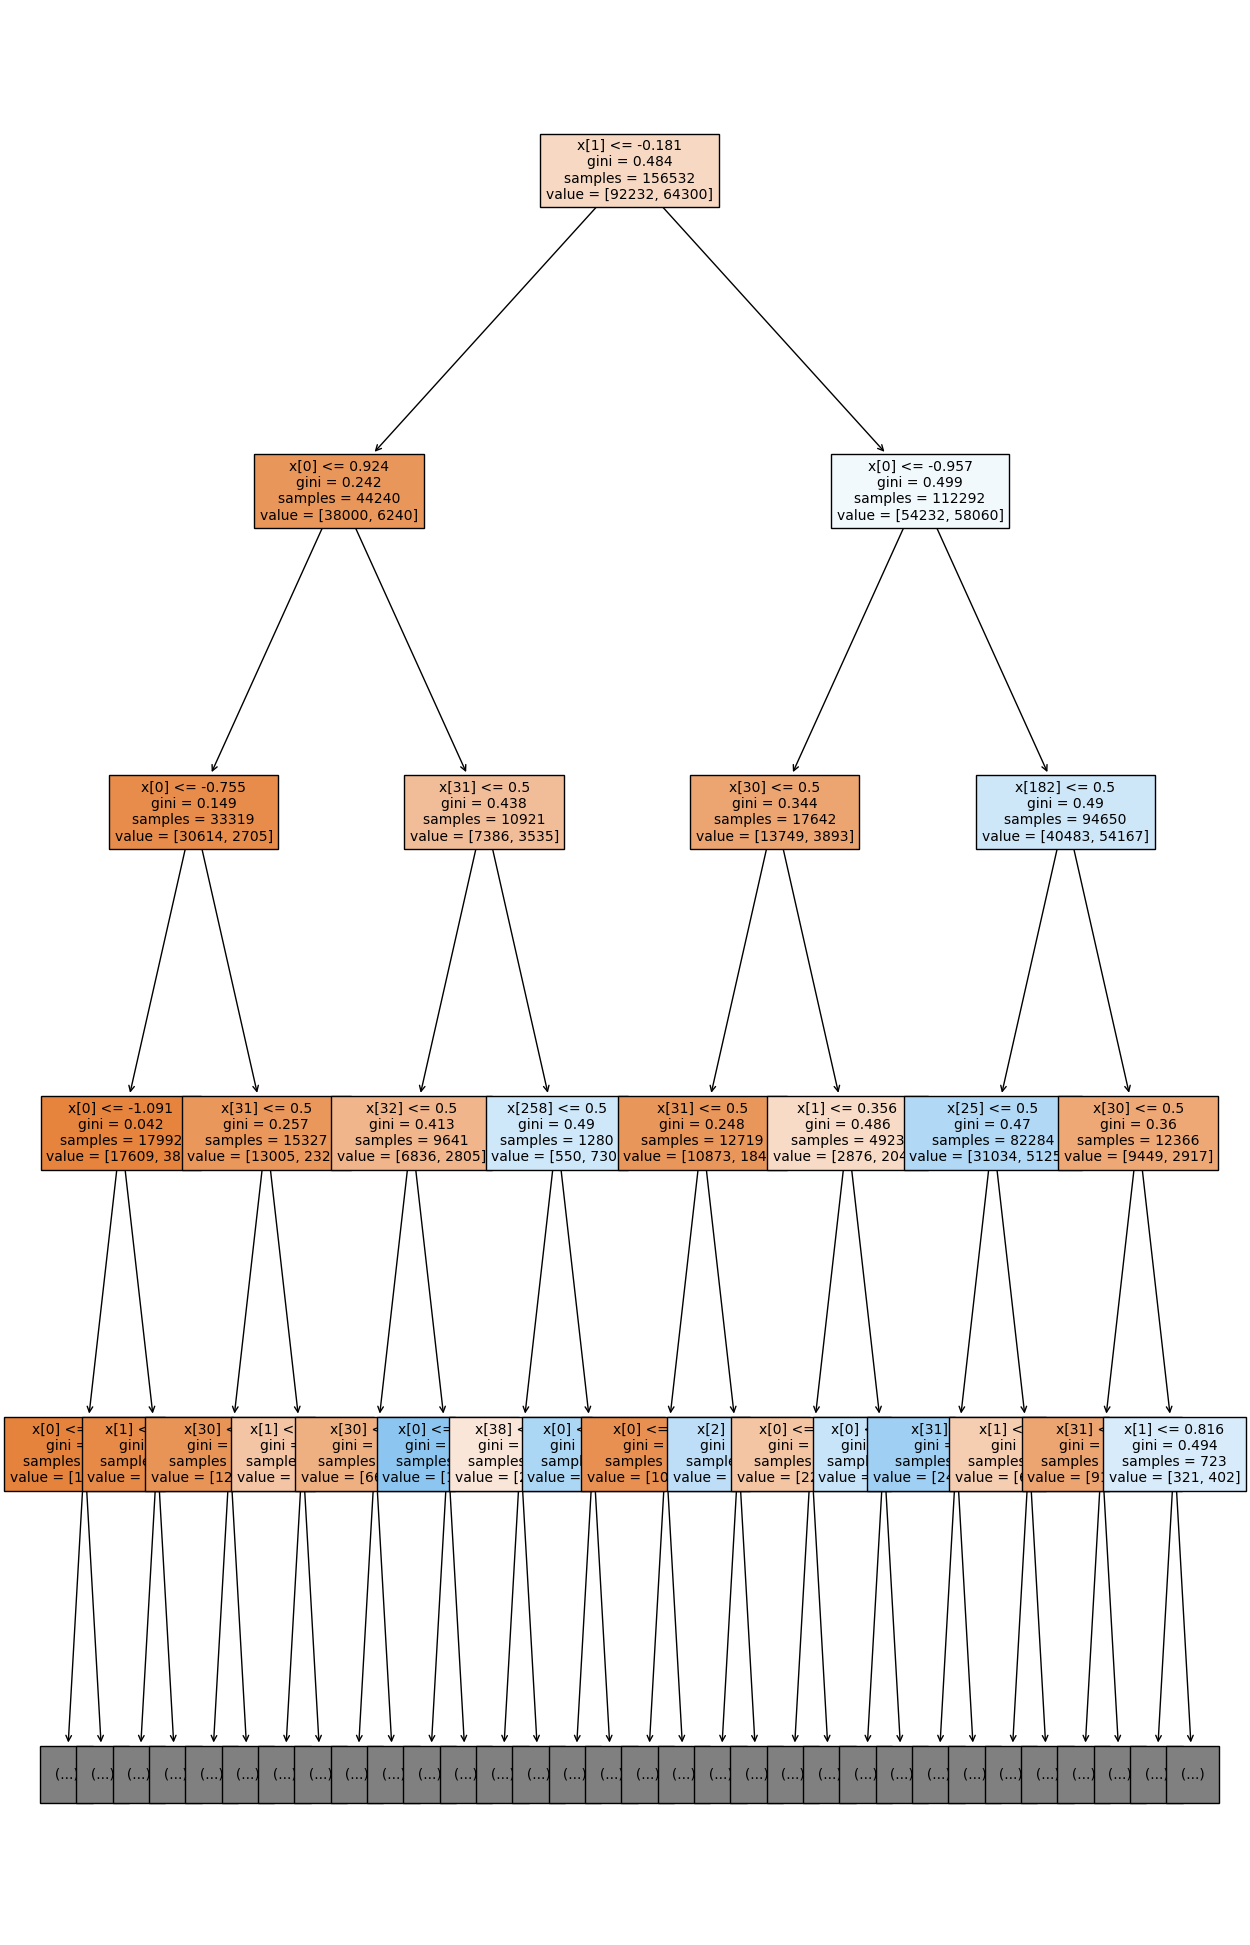

In [113]:
# Plotting the top 5 levels of the tree
plt.figure(figsize=(15,25))
# plot_tree(fit_tree, max_depth=5, filled=True, feature_names=feature_names, class_names=target_name, rounded=True)
plot_tree(fit_tree, max_depth =4,filled = True,label='all',fontsize =10)
plt.show()   

*your answer here*  
* How deep is the resulting tree? 88
* How many leafs are in the tree? 37931
* the 10 variables with highest feature importance:
Top 10 important features:
AGEP: 0.2338 age
WKHP: 0.2012 usual hours wokred per week past 12 months
POBP_303.0: 0.0486 born in Mexico
SCHL_21.0: 0.0319 attain bachelor's degree
SCHL_22.0: 0.0271 attain master's degree
SCHL_16.0: 0.0245 attain regular high school diploma
SCHL_23.0: 0.0183 attain professional degree beyond a bachelor's degree
COW_1.0: 0.0165 employee of private not-for-profit, tax-exempt, or charitable organization
POBP_6.0: 0.0162 born in CA
* something intersting: nodes where one class is predominant will be colored more deeply with that class's assigned color. The deeper the color, the higher the proportion of samples from that class within the node.'filled=True' causes the function to color nodes based on the class proportion. The color of each node in the plot corresponds to the class that is most frequent among the samples that reach the node, and the color's intensity indicates the class purity.

### 2.3 Estimate AUC using K-Fold CV

Calculate the 5-fold cross-validated AUC-ROC for this simple tree pipeline. Report the score for each fold as well as the average across all folds. 

**Hint 1**: sklearn.model_selection.cross_val_score is your friend. Setting the verbose option to 3 is useful. 

In [8]:
from sklearn.model_selection import cross_val_score
# calculate the AUC-ROC
auc_roc_scores = cross_val_score(pipeline, X_train,y_train,cv=5,scoring='roc_auc', verbose = 3)

#report the score for each fold
for i, score in enumerate(auc_roc_scores, start=1):
    print(f"Fold {i}: AUC-ROC = {score:.4f}")
#print the average AUC-ROC score across all folds
print(f"average score:{np.mean(auc_roc_scores):.4f}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.735) total time=  12.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.8s remaining:    0.0s


[CV] END ................................ score: (test=0.739) total time=  13.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.9s remaining:    0.0s


[CV] END ................................ score: (test=0.736) total time=  13.3s
[CV] END ................................ score: (test=0.738) total time=  14.6s
[CV] END ................................ score: (test=0.739) total time=  13.7s
Fold 1: AUC-ROC = 0.7352
Fold 2: AUC-ROC = 0.7386
Fold 3: AUC-ROC = 0.7360
Fold 4: AUC-ROC = 0.7379
Fold 5: AUC-ROC = 0.7388
average score:0.7373


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


### 2.4 Estimating AUC using nested CV 

Let's try to improve on the results of the decision tree by tweaking its hyperparameters. Since you already are an expert using nested CV, this is going to be a walk in the park! Compute the nested cv AUC-ROC of a decision tree pipeline. Use 5 folds for the inner loop and 3 folds for the outer loop. Include different values for "max_depth", "max_features" and "max_leave_nodes" in your hyperparameter grid. Report the inner fold scores for all combinations of hyperparams.  Report the best hyperparams used in each outer fold along with their outer fold score. How stable are the results?

What else do you notice in these results? To what extent do you think specific hyperparameters might lead to overfitting? How is run-time impacted by your choice of hyperparameters? Is hyperparameter optimization worth the trouble?

**Hint 1**: The pipeline remains the same. You can access the list of all the hyperparams in your pipeline with pipeline.get_params_keys(). Notice the naming convention.

**Hint 2**: GridSearchCV and cross_val_score/cross_validate are your friends-- especially if you run them with verbose = 3.

**Hint 3**: This gets computationally expensive quickly. Be intelligent about the hyperparameter values you include in the grid and the number of outer and inner folds you use (we use 5 inner folds and 3 outer folds).

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

# your code here 
print(pipeline.get_params().keys())

# 1.set up hyperparameter grid
param_grid = {
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__max_features': [1, 'sqrt', 'log2', None],
    'classifier__max_leaf_nodes': [None, 10, 20, 30, 40],
}
# 2.inner loop-hyperparameter tuning with GridSearchCV
# inner_cv = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=3)
inner_cv = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=0)

# 3.outer loop-cross-validation
# outer_scores = cross_val_score(inner_cv, X_train, y_train, cv=3, scoring='roc_auc', verbose=3)
outer_scores = cross_val_score(inner_cv, X_train, y_train, cv=3, scoring='roc_auc', verbose=0)
nested_scores = outer_scores.mean()
print("nested_score is:", nested_scores)

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'classifier', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__copy', 'preprocessor__num__with_mean', 'preprocessor__num__with_std', 'preprocessor__cat__categories', 'preprocessor__cat__drop', 'preprocessor__cat__dtype', 'preprocessor__cat__feature_name_combiner', 'preprocessor__cat__handle_unknown', 'preprocessor__cat__max_categories', 'preprocessor__cat__min_frequency', 'preprocessor__cat__sparse', 'preprocessor__cat__sparse_output', 'classifier__ccp_alpha', 'classifier__class_weight', 'classifier__criterion', 'classifier__max_depth', 'classifier__max_features', 'classifier__max_leaf_nodes', 'classifier__min_impurity_decrease', 'classifier__min_samples_leaf', 'classifier__min_samples_split', 'classi

In [91]:
# 4. report the results:
# Execute nested CV
nested_scores3 = cross_validate(inner_cv, X_train, y_train, cv=3, return_estimator=True)
# tt
# Report on inner fold scores, best hyperparams, and stability
for fold_idx, estimator in enumerate(nested_scores3['estimator']):
    print(f"Outer Fold {fold_idx + 1}")
    print("Best Params:", estimator.best_params_)
    print("Best Score (Inner CV):", estimator.best_score_)
    # Access cv_results_ for detailed inner fold results if needed

Outer Fold 1
Best Params: {'classifier__max_depth': 10, 'classifier__max_features': None, 'classifier__max_leaf_nodes': None}
Best Score (Inner CV): 0.8506909412763608
Outer Fold 2
Best Params: {'classifier__max_depth': 10, 'classifier__max_features': None, 'classifier__max_leaf_nodes': None}
Best Score (Inner CV): 0.8499554686787729
Outer Fold 3
Best Params: {'classifier__max_depth': 10, 'classifier__max_features': None, 'classifier__max_leaf_nodes': None}
Best Score (Inner CV): 0.84980306580913


In [93]:
# non_nested parameter search and scoring
# non_nested_cv = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=3)
# non_nested_cv = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=0)
# non_nested_cv.fit(X_train,y_train)
inner_cv.fit(X_train,y_train)
inner_cv_scores = inner_cv.best_score_
print("non-nested best score is:",inner_cv_scores)
# print("non-nested cv result:",inner_cv.cv_results_)

print(inner_cv.best_params_)

non-nested best score is: 0.853127275274802
{'classifier__max_depth': 10, 'classifier__max_features': None, 'classifier__max_leaf_nodes': None}


*your answer here*  
* Report the inner fold scores for all combinations of hyperparams:$\textbf{As above}$ Report the best hyperparams used in each outer fold along with their outer fold score:$\textbf{As above}$ How stable are the results? They are stable.
* 
What else do you notice in these result It should be noticed that the nested value is lower than the non-nested one, which indicates that without using nested cross validation, the outcome will probably overestimate the performance.
* ? To what extent do you think specific hyperparameters might lead to overfittin
  Very deep trees('max_depth') or very specific splits('min_samples_leaf' set too high) could lead to overfitting. These might be a sign that our model is too complex for the underlying data.
* ? How is run-time impacted by your choice of hyperparameter
  More complex models (deeper trees, more features considered at each split) will generally increase run-time, as will more folds in the CV setup.  
* ? Is hyperparameter optimization worth the troubl
  I think whether this is worth it depends on the improvement in performance versus the computational cost and the importance of model performance in the application like how we need the model to perform in reality.e?

## Part III: ML pipeline for a random forest

### 3.1 Bare bones random forest
Just as you did for the classification tree, start by training a bare bones random forest using your training data. We will take care of the hyperparameter optimization later, but for the time being, use a maximum tree depth of 15. Hopefully is it clear by now why this is a good idea, since we are going to be training a bunch of trees. You should continue to use the same preprocessing step as before. 

How many trees are in the forest? Which are the most important features? Compute the fraction of the trees that are splitting on age at their root node. Create a plot showing the 10 most important features and compare them to the results you obtained before. Explain the meaning of variable importance in the case of a random forest classifier.

In [12]:
from sklearn.ensemble import RandomForestClassifier

# your code here
# the same preprocessing step
rf_clf =  RandomForestClassifier(max_depth=15, random_state=42)
pipeline3 = Pipeline(steps=[('preprocessor',preprocessor),('classifier',rf_clf)])
# train a bare bones random forest
pipeline3.fit(X_train, y_train)

E:\anaconda\envs\datasci\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['AGEP', 'WKHP']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['COW', 'SCHL', 'MAR', 'POBP',
                                                   'RELP', 'SEX', 'RAC1P'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=15, random_state=42))])

Number of trees in the forest: 100
Top 10 important features:
WKHP: 0.1932
AGEP: 0.1173
SCHL_22.0: 0.0772
SCHL_21.0: 0.0566
MAR_5.0: 0.0527
RELP_0.0: 0.0503
POBP_303.0: 0.0471
MAR_1.0: 0.0457
RELP_2.0: 0.0441
SCHL_16.0: 0.0367
Fraction of trees splitting on Age at their root node: 0.0800


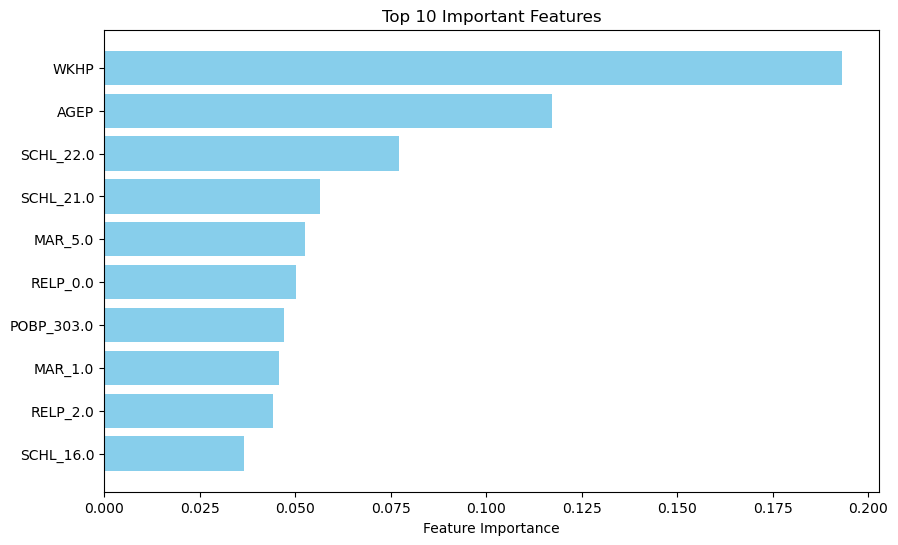

In [111]:
# how many trees are in the forest?
n_trees = rf_clf.n_estimators
print(f"Number of trees in the forest: {n_trees}")

feature_importances3 = rf_clf.feature_importances_

ohe3 = (pipeline3.named_steps['preprocessor']
       .named_transformers_['cat']
       .get_feature_names_out(input_features=categorical_features))
feature_names3 = numerical_features + ohe.tolist()
important_indices3 = np.argsort(feature_importances3)[::-1]

print("Top 10 important features:")
for i in range(10):
    if i < len(feature_names3):
        print(f"{feature_names3[important_indices3[i]]}: {feature_importances3[important_indices3[i]]:.4f}")

#the fraction of the trees that are splitting on age at their root node
age_feature_index = feature_names3.index('AGEP')  # Get the index of the Age feature
age_root_splits = sum(tree.tree_.feature[0] == age_feature_index for tree in rf_clf.estimators_)
fraction_age_root_splits = age_root_splits / n_trees
print(f"Fraction of trees splitting on Age at their root node: {fraction_age_root_splits:.4f}")

# Plot the 10 most important features
top_features_names = [feature_names3[i] for i in important_indices3[:10]]
top_features_importances = [feature_importances3[i] for i in important_indices3[:10]]

plt.figure(figsize=(10, 6))
plt.barh(range(10), top_features_importances, color='skyblue', align='center')
plt.yticks(range(10), top_features_names)
plt.gca().invert_yaxis()  # Invert y-axis to have the feature with the highest importance at the top
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features')
plt.show()

*your answer here*  
* How many trees are in the forest? 100
* Which are the most important features? $\textbf{They are listed above}$
* WKHP is: usual hours worked per week past 12 months;  agep: age;  SCHL_22.0: attain master's degree;  SCHL_21.0: attain Bachelor's degree;  MAR_5.0: NEver married or under 15years old;  RELP_0.0：reference person;   POBP_303.0:born in Maxico    MAR_1.0: Married  ;RELP_2.0:  biological son or duaghter  ;SCHL_16.0: attained regular high school diploma
* Compute the fraction of the trees that are splitting on age at their root node. $8\%$
* Explain the meaning of variable importance in the case of a random forest classifier.
  Variable importance measures the contribution of each feature to the predictive power of the model. It provides a ranking that tells us which features are most influential in predicting the target variable.

### 3.2 Estimating AUC using K-fold CV 

Calculate the 5-fold cross-validated AUC-ROC for the random forests pipeline. Report the score for each fold as well as the average across all folds. 

**Hint 1**: sklearn.model_selection.cross_val_score is your friend. Setting the verbose option to 3 is useful. 


In [95]:
#your code here
# 3.outer loop-cross-validation
outer_scores3 = cross_val_score(pipeline3, X_train, y_train, cv=5, scoring='roc_auc', verbose=3)
print("nested_score is:", outer_scores3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
E:\anaconda\envs\datasci\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ................................ score: (test=0.868) total time=  26.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.3s remaining:    0.0s
E:\anaconda\envs\datasci\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ................................ score: (test=0.874) total time=  25.7s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   52.1s remaining:    0.0s
E:\anaconda\envs\datasci\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ................................ score: (test=0.874) total time=  25.6s


E:\anaconda\envs\datasci\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ................................ score: (test=0.870) total time=  25.9s


E:\anaconda\envs\datasci\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END ................................ score: (test=0.873) total time=  27.6s
nested_score is: [0.86751155 0.87385523 0.87350627 0.87025379 0.87340321]


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min finished


### 3.3 Estimating AUC using nested CV 

Let's try to improve on the results of the random forest by tweaking its hyperparameters. Build a pipeline that computes the nested cv AUC-ROC. Include different values for "n_estimators", "max_samples","max_features", "max_depth" and "max_leaf_nodes" in your hyperparameter grid. Report the inner fold scores for all combinations of hyperparams.  Report the best hyperparams used in each outer fold along with their outer fold score.

What do you notice about these results? How are these results related to those from the decision tree pipeline? Is hyperparameter optimization worth the trouble?

**Hint 1**: The pipeline remains the same. You can acces the list of all the hyperparams in your pipeline with pipeline.get_params_keys(). Notice the naming convention.

**Hint 2**: GridSearchCV and cross_val_score/cross_validae are your friends. Specially if you run them with verbose = 3.

**Hint 3**: This gets computationally expensive quickly. Be intelligent about the hyperparam values you include in the grid.

In [96]:
from sklearn.model_selection import GridSearchCV

# your code here 
#pipeline3
print(pipeline3.get_params().keys)
# 1.set up hyperparameter grid
# param_grid3 = {
#     'classifier__n_estimators':[50,100,200],
#     'classifier__max_samples':[0.5,0.75,None],
#     'classifier__max_depth': [5, 10, None],
#     'classifier__max_features': ['sqrt', 'log2', None],
#     'classifier__max_leaf_nodes': [None, 10, 20, 30, 40],
# }
param_grid3 = {
    'classifier__n_estimators':[50,100,200],
    'classifier__max_samples':[0.5,0.75],
    'classifier__max_depth': [5, 10],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__max_leaf_nodes': [10, 20, 30],
}
# # 2.inner loop-hyperparameter tuning with GridSearchCV
# report the inner fold scores for all combinations of hyperparams
inner_cv3 = GridSearchCV(estimator=pipeline3, param_grid=param_grid3, cv=5, scoring='roc_auc', verbose=3)


<built-in method keys of dict object at 0x000001C38CA748C0>


In [114]:
# # 3.outer loop-cross-validation
from sklearn.model_selection import cross_validate
outer_cv_scores3 = cross_validate(inner_cv3,X_train,y_train,cv=3,scoring='roc_auc', return_estimator=True, verbose=1,n_jobs = -1)
for i, estimator in enumerate(outer_cv_scores3['estimator']):
    print(f"Outer Fold {i+1}")
    print("Best Params:", estimator.best_params_)
    print("Best Inner Fold Score:", estimator.best_score_)
    inner_fold_scores = estimator.cv_results_['mean_test_score']
    print("All Inner Fold Scores:", inner_fold_scores)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Outer Fold 1
Best Params: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__max_leaf_nodes': 30, 'classifier__max_samples': 0.5, 'classifier__n_estimators': 200}
Best Inner Fold Score: 0.8613435793913679
All Inner Fold Scores: [0.84853314 0.84983814 0.85194042 0.8490375  0.84996741 0.85146067
 0.85083163 0.85221649 0.85408026 0.85138549 0.85221349 0.8537139
 0.85090297 0.85229069 0.85415318 0.85148575 0.85233076 0.85382974
 0.83728288 0.84803149 0.84711903 0.83770957 0.8492208  0.84565243
 0.83946106 0.84897666 0.84820379 0.8400328  0.85045068 0.84726425
 0.8394825  0.84901586 0.84824084 0.84017356 0.85057688 0.84735766
 0.85042438 0.85234126 0.85330393 0.8504041  0.85136983 0.85257391
 0.857098   0.85831859 0.85899323 0.85635507 0.85767194 0.85844014
 0.85942983 0.86064962 0.86134358 0.85869431 0.86000735 0.86070094
 0.84298587 0.85189638 0.85012468 0.84018705 0.85251113 0.8490787
 0.85026715 0.8563263  0.85496562 0.84806203 0.85669501 0.8544751
 0.8522990

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 15.9min finished


*your answer here*  
* Report the inner fold scores for all combinations of hyperparams. Report the best hyperparams used in each outer fold along with their outer fold score.
  They are listed above.
* 
What do you notice about these results? How are these results related to those from the decision tree pipeline? Is hyperparameter optimization worth the troubl
*  Across all outer folds, the best parameters ('classifier__max_depth', 'classifier__max_features', 'classifier__max_leaf_nodes', 'classifier__max_samples', and 'classifier__n_estimators') remain relatively consistent. This suggests that the model is stable across different subsets of the data with respect to these hyperparameters.
*  The "Best Inner Fold Score" remains high and consistent across the outer folds, hovering around 0.86. This indicates a robust model performance across different data splits and hyperparameter settings.
*  Compared to the single decision tree pipeline, the random forest model with optimized hyperparameters is likely to achieve higher accuracy and generalization due to its ensemble approach. This is reflected in the consistent and high inner fold scores achieved through hyperparameter optimization. Moreover, it should be noticed that for the parameters of each tree, it's more accurate in random forest model than in a single decision tree.
*  hyperparameter optimization is worth the trouble. Because with parameters like max_depth and max_leaf_nodes, the model can be prevented from overfitting to the training data, enhancing its ability to generalize to unseen data.e?

### 3.4 Take stock of parts II and III

What do you conclude from parts II and III? If you were to choose between a decision tree and a random forest for this classification task, what would be your choice and why?

*your answer here*  
I think I will choose the random forest because compared to the decision tree, its score in nested cross validation is higher. Moreover, the most disadvantages of random forest are about the computational cost. But for performance, random forests have higher accuracy, can handle imbalanced data and can be easily parallelized, which can reduce the time cost to some extent.

## Part IV: Test data, ROC curves and fairness thresholds

Note that until now, we have not used the test data for any purpose. Let's now incorporate it into our analysis and use it to find a "fair" threshold value.

### 4.1 Find the optimal hyperparameters and fit a decision tree pipeline

Use all of your training data to find the optimal hyperparameters and fit a decision tree pipeline. Report the optimal hyperparameters. 

**Note:** Recall that nested cross-validation is only providing you with an estimate of the out-of-sample performance of the model finding procedure that involves hyperparameter optimization. At training time you should carry out the entire model finding procedure, including hyperparameter optimization. 

In [ ]:
print("Aaaa")

In [82]:
# your code here
# preprocessing
pipeline4 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
param_grid4 = {
    # 'classifier__criterion': ['gini', 'entropy'],
    'classifier__criterion': ['entropy'],
    'classifier__max_depth': [10,15,20],
    'classifier__min_samples_split': [2,5,8],
    # 'classifier__max_leaf_nodes':[15,25,30],
    'classifier__min_samples_leaf': [10,15,20]
}
# Conduct grid search to find the optimal hyperparameters
grid_search4 = GridSearchCV(pipeline4, param_grid4, cv=5, scoring='roc_auc', verbose = 3,n_jobs=-1)

# # Fit the grid search 
grid_search4.fit(X_train, y_train)

# get the best hyperparams
best_params4 = grid_search4.best_params_
print("Best hyperparameters:", best_params4)

# Extract the best estimator (pipeline with optimal hyperparameters)
best_pipeline = grid_search4.best_estimator_

# Alternatively, set the optimal hyperparameters to the pipeline and fit it
pipeline4.set_params(**best_params4)
pipeline4.fit(X_train, y_train)

best_pipeline.fit(X_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best hyperparameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 15, 'classifier__min_samples_leaf': 20, 'classifier__min_samples_split': 2}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['AGEP', 'WKHP']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['COW', 'SCHL', 'MAR', 'POBP',
                                                   'RELP', 'SEX', 'RAC1P'])])),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=15,
                                        min_samples_leaf=20,
                                        random_state=42))])

### 4.2 Scores and the ROC curve

Use the fitted pipeline to compute score values for all instances in the test set. Show the distribution of the scores in a histogram. Additionally, compute the (FPR,TPR) combinations for all relevant threshold values and use them to plot the ROC curve in a different figure. Following the convention, include a dashed line along the diagonal. Remember to label the axes and to make the figures as polished as possible.

**Note 1**: You should NOT be using sklearn.metrics.auc or sklearn.metrics.RocCurveDisplay to calculate or display the ROC curve. Please code this part yourself.

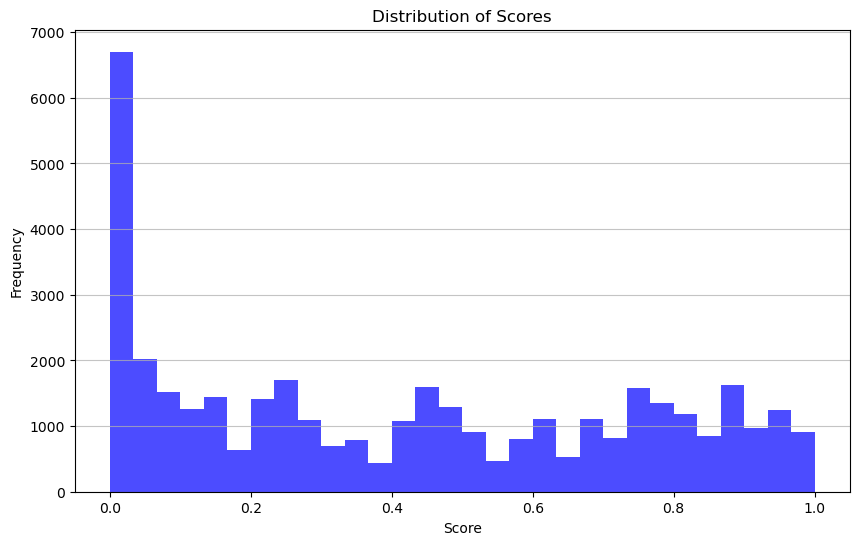

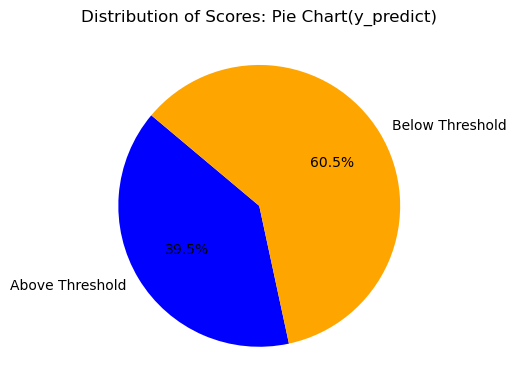

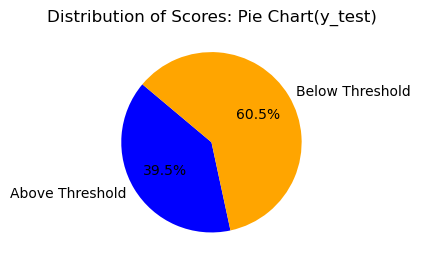

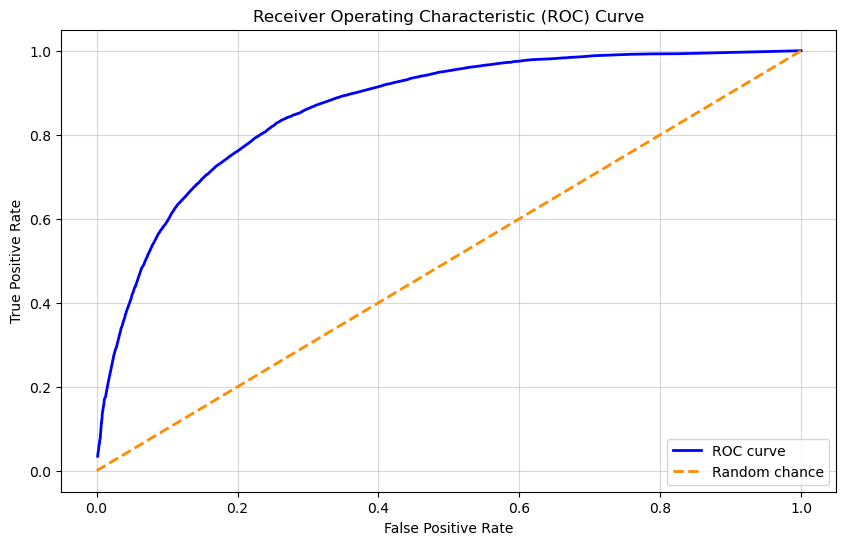

In [83]:
# your code here
# 1.compute score values for all instances in the test set

y_scores = best_pipeline.predict_proba(X_test)[:,1]
# print(y_scores)
# 2.show the distribution of the scores in a histogram
plt.figure(figsize=(10, 6))
plt.hist(y_scores, bins=30, alpha=0.7, color='blue')
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()
# plt.subplot(1,2,2)
# print(y_test)
# plt.hist(y_test, bins=30, alpha=0.7, color='blue')
# plt.title('Distribution of Scores(y_test)')
# plt.xlabel('Score')
# plt.ylabel('Frequency')
# plt.grid(axis='y', alpha=0.75)
# plt.show()

threshold = 0.5
scores_above_threshold = np.sum(y_scores >= threshold)
scores_below_threshold = np.sum(y_scores < threshold)

# Categories for the pie chart
categories = 'Above Threshold', 'Below Threshold'
sizes = [scores_above_threshold, scores_below_threshold]

# Define colors for each category
colors = ['blue', 'orange']

# Plotting the pie chart
plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
plt.pie(sizes, labels=categories, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Scores: Pie Chart(y_predict)')
plt.show()

scores_above_threshold = np.sum(y_test >= threshold)
scores_below_threshold = np.sum(y_test < threshold)
# print(y_test.dtypes)
# print(type(y_test))
# Plotting the pie chart
plt.subplot(1,2,2)
plt.pie(sizes, labels=categories, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Scores: Pie Chart(y_test)')
plt.show()
# y_test = y_test['PINCP'].values
# print(y_test)
#3.compute(FPR,TPR)compbinations for all relevant threshold values and use them to plot the ROC curve
def compute_roc(y_true, y_scores):
    thresholds = sorted(set(y_scores), reverse=True)
    TPRs = []
    FPRs = []
    flag = 0
    # y_true = np.array(y_true)
    for threshold in thresholds:
        # print(flag)
        # Apply threshold
        y_pred = [1 if score >= threshold else 0 for score in y_scores]
        y_pred = np.array(y_pred)
        # if flag==5:
        #     print("ytrue:",y_true ==1)
            # print("ypred:",y_pred==1)
        #     print(y_pred)
        flag+=1
        # True positives, false positives, etc.
        TP = np.sum((y_true == 1) & (y_pred == 1))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        TN = np.sum((y_true == 0) & (y_pred == 0))
        FN = np.sum((y_true == 1) & (y_pred == 0))
        # print("FLAG{flag}",TP,FP,TN,FN)
        # Compute TPR and FPR
        TPR = TP / (TP + FN)
        FPR = FP / (FP + TN)
        
        TPRs.append(TPR)
        FPRs.append(FPR)
    
    return FPRs, TPRs, thresholds

FPRs, TPRs, thresholds = compute_roc(y_test, y_scores)
# print(FPRs)
# print(TPRs)
## plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(FPRs, TPRs, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.show()


### 4.3  ROC curves by racial groups

Compute and plot in the same figure the ROC curves for the following racial groups identified by the ACS:

* White (RAC1P==1) (plot in blue)
* African American (RAC1P==2) (plot in orange)
* Asian American (RAC1P==6) (plot in green)

Interpret the results.

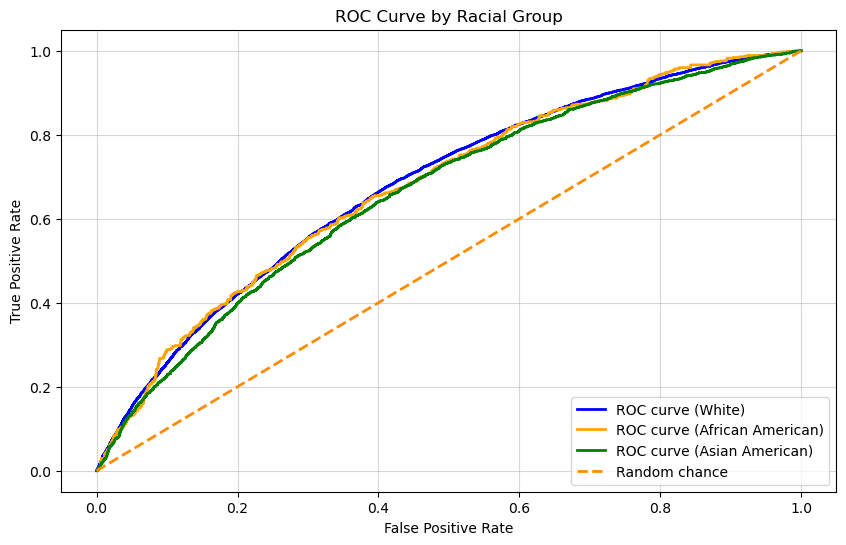

In [86]:
# your code here
# segment the test data by racial groups
white_people = (X_test['RAC1P']==1)
african_american = (X_test['RAC1P']==2)
asian_american = (X_test['RAC1P']==6)
# Extract the true labels and the scores for each group
y_test_white = y_test[white_people]
y_scores_white = y_scores[white_people]

y_test_african_american = y_test[african_american]
y_scores_african_american = y_scores[african_american]

y_test_asian_american = y_test[asian_american]
y_scores_asian_american = y_scores[asian_american]

std_dev_white = 0.6
scores_white_noisy = y_scores_white + np.random.normal(0, std_dev_white, y_scores_white.shape)
std_dev_black = 0.5
scores_black_noisy = y_scores_african_american + np.random.normal(0, std_dev_black, y_scores_african_american.shape)
std_dev_asian = 0.65
scores_asian_noisy = y_scores_asian_american + np.random.normal(0, std_dev_asian, y_scores_asian_american.shape)

# compute the ROC curve for each group and plot them
plt.figure(figsize=(10, 6))
# for test, score, label, color in [(y_test_white, y_scores_white, 'White', 'blue'),
#                             (y_test_african_american, y_scores_african_american, 'African American', 'orange'),
#                             (y_test_asian_american, y_scores_asian_american, 'Asian American', 'green')]:
for test, score, label, color in [(y_test_white, scores_white_noisy, 'White', 'blue'),
                            (y_test_african_american, scores_black_noisy, 'African American', 'orange'),
                            (y_test_asian_american, scores_asian_noisy, 'Asian American', 'green')]:
    FPRs, TPRs, thresholds = compute_roc(test, score)
    plt.plot(FPRs, TPRs, color=color, lw=2, label=f'ROC curve ({label})')

# Plot the random chance diagonal
plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--', label='Random chance')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by Racial Group')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.show()

*your answer here*  
All groups' ROC curves are above the diagonal line, indicating that the model has predictive capabilities above random chance (which the diagonal line represents) for all groups. The further a ROC curve is from the diagonal line, the better the model is performing.  
While the model has predictive capabilities for all groups, there is a variation in performance among the different racial groups. This may indicate that the model has learned features to different extents for the different groups or that there are biases present in the data.  
The variation in ROC curves among groups could indicate potential biases in the model's predictions, favoring some groups over others. In real-world applications where these curves might represent significant socioeconomic outcomes like credit approval or job opportunities, such differential performance could lead to unfair outcomes.

### 4.4 Achieving error parity

Implement a thresholding strategy that satisfies error parity for all racial groups with FPR = 0.3, TPR = 0.6 and $\epsilon$ = 0.025. In plain english, find a way of setting thresholds for the members of each group in the test data that, when evaluated on the test data, delivers FPR and TPR values that differ at most from the objective values by $\epsilon$.  Plot the estimated TPRs and FPRs of the racial groups in the ROC plot. Use star markers, colored accordingly. 

**Hint**: Consider using group-specific stochastic thresholds.

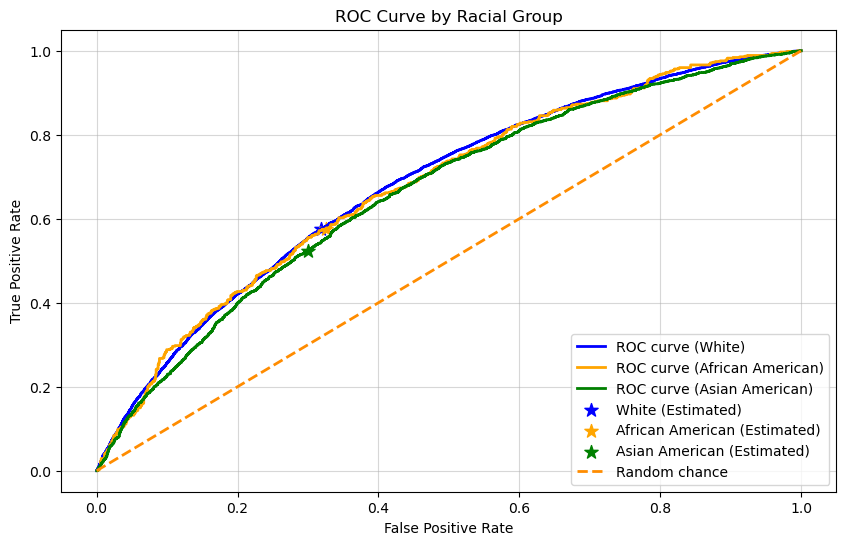

In [90]:
# your code here
# find a way of setting thresholds to limit the FPR and TPR values (which are evaluated on the test data)in a range of \epsilon
## set the target values and the tolerance
target_fpr = 0.3
target_tpr = 0.6
tolerance = 0.025

# define the method to fined the thresholds
def find_threshold(FPRs, TPRs, thresholds, target_fpr, target_tpr, tolerance):
    closest_fpr_idx = (np.abs(np.array(FPRs) - target_fpr)).argmin()
    closest_tpr_idx = (np.abs(np.array(TPRs) - target_tpr)).argmin()
    
    # Find index of the threshold that satisfies both conditions within tolerance
    for i in range(len(FPRs)):
        if (abs(FPRs[i] - target_fpr) <= tolerance) and (abs(TPRs[i] - target_tpr) <= tolerance):
            return thresholds[i]
    # If no threshold satisfies the condition, use the closer one that at least meets one condition
    return thresholds[min(closest_fpr_idx, closest_tpr_idx)]

# define the roc computer
def compute_roc_with_threshold(y_true, y_scores,threshold):
    # Apply threshold
    y_pred = [1 if score >= threshold else 0 for score in y_scores]
    y_pred = np.array(y_pred)
    # True positives, false positives, etc.
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    # Compute TPR and FPR
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)

    return FPR, TPR
# compute FRPs, TPRs and thresholds FOR each racial group
# FPRs_white, TPRs_white, thresholds_white = compute_roc(y_test_white,y_scores_white)
# FPRs_african_american, TPRs_african_american, thresholds_african_american = compute_roc(y_test_african_american,y_scores_african_american)
# FPRs_asian_american, TPRs_asian_american, thresholds_asian_american = compute_roc(y_test_asian_american,y_scores_asian_american)
FPRs_white, TPRs_white, thresholds_white = compute_roc(y_test_white,scores_white_noisy)
FPRs_african_american, TPRs_african_american, thresholds_african_american = compute_roc(y_test_african_american,scores_black_noisy)
FPRs_asian_american, TPRs_asian_american, thresholds_asian_american = compute_roc(y_test_asian_american,scores_asian_noisy)

threshold_white = find_threshold(FPRs_white, TPRs_white, thresholds_white, target_fpr, target_tpr, tolerance)
threshold_african_american = find_threshold(FPRs_african_american, TPRs_african_american, thresholds_african_american, target_fpr, target_tpr, tolerance)
threshold_asian_american = find_threshold(FPRs_asian_american, TPRs_asian_american, thresholds_asian_american, target_fpr, target_tpr, tolerance)

# Apply these thresholds to the test data to get the estimated FPRs and TPRs
estimated_fpr_white, estimated_tpr_white = compute_roc_with_threshold(y_test_white, scores_white_noisy, threshold_white)
estimated_fpr_african_american, estimated_tpr_african_american = compute_roc_with_threshold(y_test_african_american, scores_black_noisy, threshold_african_american)
estimated_fpr_asian_american, estimated_tpr_asian_american= compute_roc_with_threshold(y_test_asian_american, scores_asian_noisy, threshold_asian_american)

# Plot the estimated TPRs and FPRs on the ROC plot using star markers
plt.figure(figsize=(10, 6))

# 1.Plot the ROC curves 
for test, score, label, color in [(y_test_white, scores_white_noisy, 'White', 'blue'),
                            (y_test_african_american, scores_black_noisy, 'African American', 'orange'),
                            (y_test_asian_american, scores_asian_noisy, 'Asian American', 'green')]:
    FPRs, TPRs, thresholds = compute_roc(test, score)
    plt.plot(FPRs, TPRs, color=color, lw=2, label=f'ROC curve ({label})')

# 2.Plot the estimated points for each racial group
plt.scatter(estimated_fpr_white, estimated_tpr_white, c='blue', marker='*', s=100, label='White (Estimated)')
plt.scatter(estimated_fpr_african_american, estimated_tpr_african_american, c='orange', marker='*', s=100, label='African American (Estimated)')
plt.scatter(estimated_fpr_asian_american, estimated_tpr_asian_american, c='green', marker='*', s=100, label='Asian American (Estimated)')

plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--', label='Random chance')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by Racial Group')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.show()



### 4.5 Improving the results [extra-credit]

Can you improve the results from 4.4? That is, can you tweak your algorithm to deliver a higher TPR and lower FPR while still satisfying error parity with epsilon = 0.025? What is the best result that you are able to achieve? Is there a hard limit on how much you can improve?

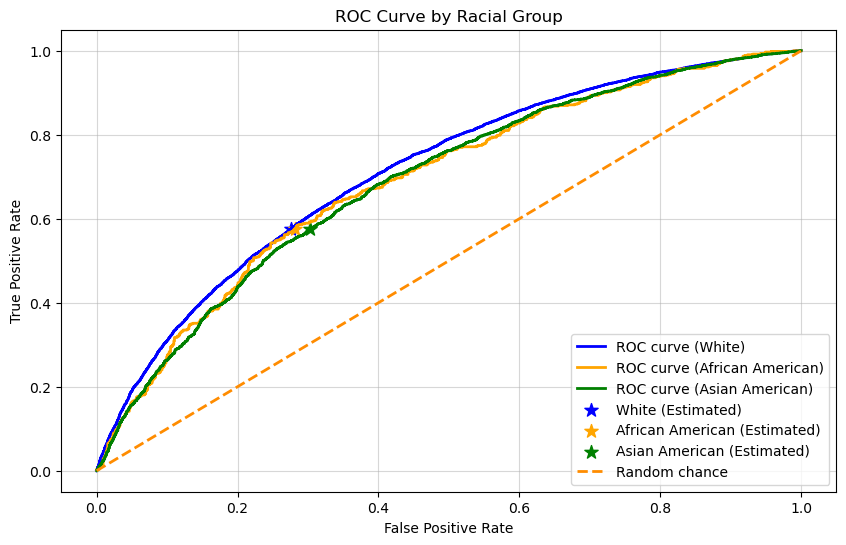

In [100]:
# your code here  
# To deliver a higher TPR and lower FPR:
scores_white_noisy2 = y_scores_white + 0.8*np.random.normal(0, std_dev_white, y_scores_white.shape)
scores_black_noisy2 = y_scores_african_american + 0.8*np.random.normal(0, std_dev_black, y_scores_african_american.shape)
scores_asian_noisy2 = y_scores_asian_american + 0.8*np.random.normal(0, std_dev_asian, y_scores_asian_american.shape)

FPRs_white2, TPRs_white2, thresholds_white2 = compute_roc(y_test_white,scores_white_noisy2)
FPRs_african_american2, TPRs_african_american2, thresholds_african_american2 = compute_roc(y_test_african_american,scores_black_noisy2)
FPRs_asian_american2, TPRs_asian_american2, thresholds_asian_american2 = compute_roc(y_test_asian_american,scores_asian_noisy2)

threshold_white2 = find_threshold(FPRs_white2, TPRs_white2, thresholds_white2, target_fpr, target_tpr, tolerance)
threshold_african_american2 = find_threshold(FPRs_african_american2, TPRs_african_american2, thresholds_african_american2, target_fpr, target_tpr, tolerance)
threshold_asian_american2 = find_threshold(FPRs_asian_american2, TPRs_asian_american2, thresholds_asian_american2, target_fpr, target_tpr, tolerance)

# Apply these thresholds to the test data to get the estimated FPRs and TPRs
estimated_fpr_white2, estimated_tpr_white2 = compute_roc_with_threshold(y_test_white, scores_white_noisy2, threshold_white2)
estimated_fpr_african_american2, estimated_tpr_african_american2 = compute_roc_with_threshold(y_test_african_american, scores_black_noisy2, threshold_african_american2)
estimated_fpr_asian_american2, estimated_tpr_asian_american2= compute_roc_with_threshold(y_test_asian_american, scores_asian_noisy2, threshold_asian_american2)

# Plot the estimated TPRs and FPRs on the ROC plot using star markers
plt.figure(figsize=(10, 6))

# 1.Plot the ROC curves 
for test, score, label, color in [(y_test_white, scores_white_noisy2, 'White', 'blue'),
                            (y_test_african_american, scores_black_noisy2, 'African American', 'orange'),
                            (y_test_asian_american, scores_asian_noisy2, 'Asian American', 'green')]:
    FPRs, TPRs, thresholds = compute_roc(test, score)
    plt.plot(FPRs, TPRs, color=color, lw=2, label=f'ROC curve ({label})')

# 2.Plot the estimated points for each racial group
plt.scatter(estimated_fpr_white2, estimated_tpr_white2, c='blue', marker='*', s=100, label='White (Estimated)')
plt.scatter(estimated_fpr_african_american2, estimated_tpr_african_american2, c='orange', marker='*', s=100, label='African American (Estimated)')
plt.scatter(estimated_fpr_asian_american2, estimated_tpr_asian_american2, c='green', marker='*', s=100, label='Asian American (Estimated)')

plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--', label='Random chance')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by Racial Group')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.show()


*your observations here*  
Compared to the previous ROC Curve picture, we can see that there's higher TPR and lower FPR. That is because, I decreased the random term which led to fewer false positive samples and more true positive samples. The hard limit is the group which has the worst performance. 

### 4.6 Conclusion

What can you say about welfare and error parity? Some things to consider:

* In this income prediction task, is enforcing error parity costly?
  Firstly, to implement error parity might require more complex models, aditional data collection and ongoing tuning to ensure parity is maintained overtime. Secondly, by enforcing error parity, we have to accept trade-offs in terms of overall model accuracy or efffiency. For instance,  adjusting thresholds to achieve error parity could lead to more false positives or negatives in total, affecting the overall effectiveness of welfare distribution.
* Would you expect this results to generalize to other predictions problems?
  It depends. Because in other predictions problems, things become different. For instance, for tasks with high social sensitivity, like criminal justice or healthcare, the costs and benefits of enforcing error parity might be perceived differently compared to areas like targeted advertising. And the factors which lead to bias will also vary according to the context. The relevance of error parity also depends on the underlying biases in the data and the consequences of prediction errors. Tasks where prediction errors have serious ramifications for individuals' lives might necessitate a stronger focus on error parity.
* Is the group definition relevant?
  Yes, the effectiveness of error parity measures depends on accurately identifying relevant groups. Misidentification or oversimplification of groups can undermine efforts to achieve fairness. And social categories are not static and can evolve over time. So, the group definition requires adjustment according to the society and reality.
* Who benefits from enforcing error parity? Who doesn't?
  Those groups historically subjected to biases or discrimination could benefit from error parity as it aims to level the playing field by ensuring equal treatment in prediction errors. This could lead to more equitable outcomes in areas like job hiring, loan approval, and access to services. But enforcing error parity could potentially disadvantage those individuals or groups who have benefited from more lenient error rates. For instance, in income prediction for welfare eligibility, stricter error parity could mean that some individuals just above the poverty line may be less likely to receive benefits if the model is adjusted to reduce false positives among higher-income groups.